In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                             GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

In [3]:
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


범주형 변수에서 인사이트를 얻으려고 해야함

In [4]:
full_data = [train, test]

train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

train['Has_Cabin'] = train['Cabin'].apply(lambda x : 0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x : 0 if type(x) == float else 1)

for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
    
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

#결측치 처리하는 되게 신박한 방법임([m-sigma, m+sigma] 사이에 존재하는 임의의 정수)
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std,
                                            age_avg + age_std, size = age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

train['CategoricalAge'] = pd.qcut(train['Age'], 5)

# 이름 추출 위해 함수 정의
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    #title이 있으면, 추출
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map({'female' : 0, 'male' : 1}).astype(int)
    title_mapping = {"Mr" : 1, "Miss" : 2, "Mrs" : 3, "Master" : 4, "Rare" : 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    dataset['Embarked'] = dataset['Embarked'].map({'S':0, 'C' : 1, 'Q' : 2}).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [5]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test = test.drop(drop_elements, axis = 1)

<h3>시각화

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

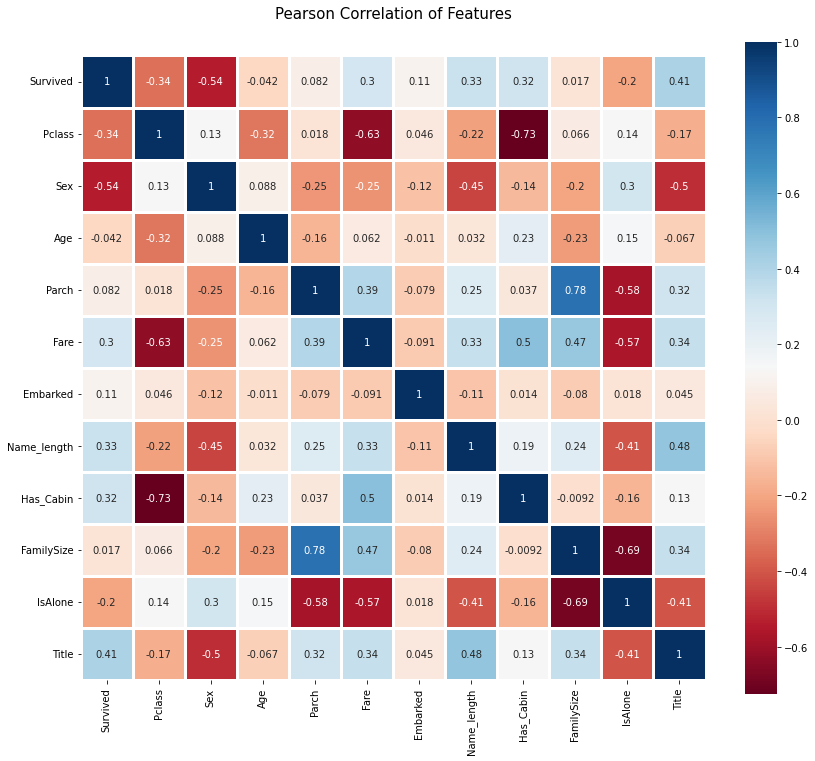

In [6]:
#상관관계 찾아보기
colormap = plt.cm.RdBu
plt.figure(figsize = (14, 12))
plt.title('Pearson Correlation of Features', y = 1.05, size = 15) #y는 title위치 
sns.heatmap(train.astype(float).corr(), linewidths = 3, vmax = 1.0,
           square = True, cmap = colormap, linecolor = 'white', annot = True)
#linewidth -> 선과 선 사이의 간격?, vmax : 색깔범위 설정(max), square : 상관관계 표시 square로?

<h4> 상관관계를 그림으로써 알 수 있는 것들 </h4>
<li>서로 강하게 연관이 되어있는 지, 아닌 지를 판단할 수 있음</li>
<li>만약 서로 강하게 연관되어 있다는 것이 많지 않다면, 이건 불필요한 컬럼이 많이 없다는 것임</li>
<li>위에서 말한 것은 결국, 고유한 정보를 가지고 있다는 사실에 만족하기 때문에, 학습 모델에 이러한 기능을 제공한다는 관점에서 좋다</li>

<h3> pairplot을 그려보면서 각 피쳐별로 어떤 관계가 있는 지를 볼 수 있음 </h3>

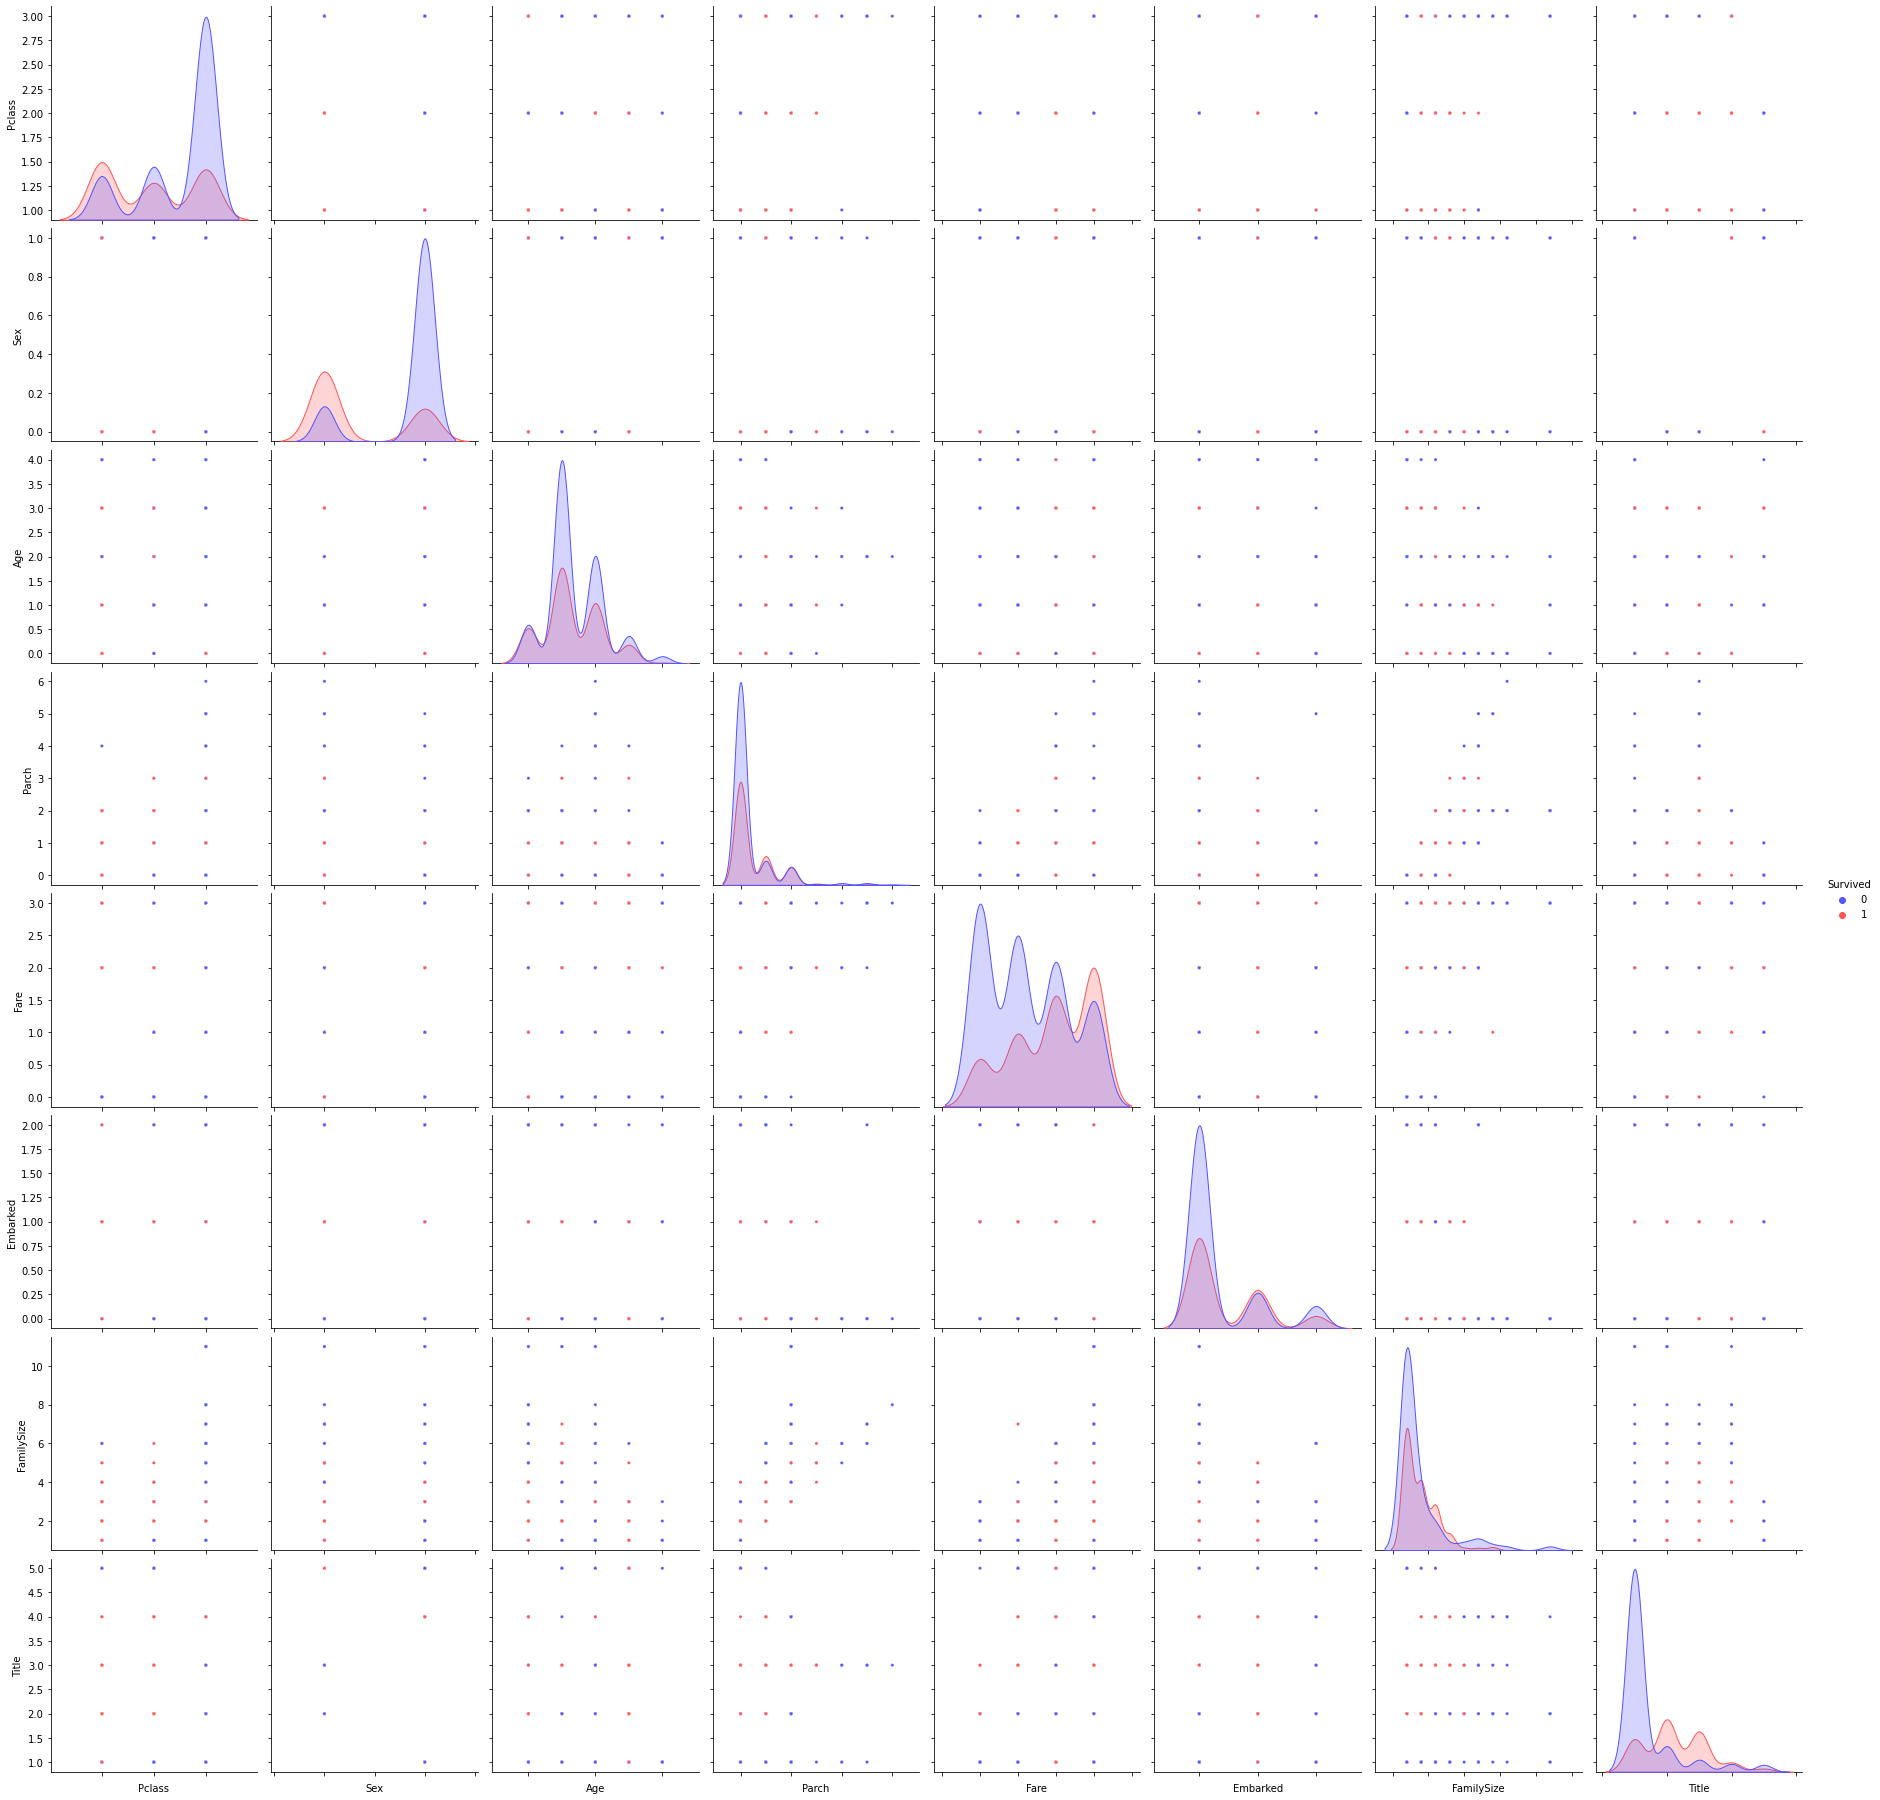

In [7]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue = 'Survived', palette = 'seismic', size = 3.2,
                 diag_kind = 'kde', diag_kws = dict(shade = True), plot_kws = dict(s = 10))

g.set(xticklabels=[])
# diag_kind : 대각선 성분들에 대해서 그림을 어떻게 그릴 것인지?
# diag_kws : 대각선 성분들에 대해 어떻게 접근할 것인지?
# plot_kws : 각각의 그래프에 전달할 인자값들

<h2> Modeling </h2>

In [8]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(n_splits = NFOLDS, random_state = SEED, shuffle = True)

# 모델 돌리는 sklearn helper 클래스 생성
class SKlearnHelper(object):
    def __init__(self, clf, seed = 0, params = None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        print(self.clf.fit(x, y).feature_importances_)

In [9]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain, ))
    oof_test = np.zeros((ntest, ))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
    oof_test[:] = oof_test_skf.mean(axis = 0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

<p> 메타 모델이 아닌, 첫 번째 베이스라인 모델 구축 </p>
<li> RandomForestClassifier</li>
<li> ExtraTreesClassifier </li>
<li> AdaBoostClassifier </li>
<li> GradientBoostingClassifier </li>
<li> Support Vector Machine </li>

In [10]:
rf_params = {
    'n_jobs' : -1,
    'n_estimators' : 500,
    'warm_start' : True,
    'max_depth' : 6,
    'min_samples_leaf' : 2,
    'max_features': 'sqrt',
    'verbose' : 0
}

et_params = {
    'n_jobs' : -1,
    'n_estimators' : 500,
    'max_depth' : 8,
    'min_samples_leaf' : 2,
    'verbose' : 0
}

ada_params = {
    'n_estimators' : 500,
    'learning_rate' : 0.75
}

gb_params = {
    'n_estimators' : 500,
    'max_depth' : 5,
    'min_samples_leaf' : 2,
    'verbose' : 0
}
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
}

In [11]:
rf = SKlearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SKlearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SKlearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SKlearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SKlearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [12]:
train

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,1,0,1,0,21,0,1,1,5
887,1,1,0,1,0,2,0,28,1,1,1,2
888,0,3,0,1,2,2,0,40,0,4,0,2
889,1,1,1,1,0,2,1,21,1,1,1,1


In [13]:
# train, test 학습시키기 위해 numpy array 생성하기
y_train = train['Survived'].ravel() #배열을 1차원으로 변환 // 여기서는 시리즈를 1차원으로 변환시
train = train.drop('Survived', axis = 1)
x_train = train.values
x_test = test.values

In [14]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


<p> 각 분류 모델로부터 feature importance 도출해보기 </p>

In [15]:
rf_feature = rf.feature_importances(x_train, y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train, y_train)

[0.10369971 0.21390419 0.03137563 0.02044015 0.04785631 0.02874241
 0.13053942 0.04888297 0.07079885 0.0118526  0.29190777]
[0.11943586 0.38081582 0.02896679 0.01708429 0.05487404 0.02892516
 0.04738194 0.08514281 0.04366501 0.0217228  0.17198548]
[0.028 0.012 0.012 0.066 0.038 0.01  0.694 0.016 0.05  0.006 0.068]
[0.08776844 0.01237422 0.05414261 0.01399872 0.0490468  0.0234678
 0.16872352 0.03730123 0.11116677 0.00637934 0.43563057]


In [16]:
rf_features = [0.10474135,  0.21837029,  0.04432652,  0.02249159,  0.05432591,  0.02854371
  ,0.07570305,  0.01088129 , 0.24247496,  0.13685733 , 0.06128402]
et_features = [ 0.12165657,  0.37098307  ,0.03129623 , 0.01591611 , 0.05525811 , 0.028157
  ,0.04589793 , 0.02030357 , 0.17289562 , 0.04853517,  0.08910063]
ada_features = [0.028 ,   0.008  ,      0.012   ,     0.05866667,   0.032 ,       0.008
  ,0.04666667 ,  0.     ,      0.05733333,   0.73866667,   0.01066667]
gb_features = [ 0.06796144 , 0.03889349 , 0.07237845 , 0.02628645 , 0.11194395,  0.04778854
  ,0.05965792 , 0.02774745,  0.07462718,  0.4593142 ,  0.01340093]


cols = train.columns.values

feature_dataframe = pd.DataFrame({'features' : cols,
                                 'Random Forest feature importances' : rf_features,
                                 'Extra Trees feature importances' : et_features,
                                 'AdaBoost feature importances' : ada_features,
                                 'Gradient Boost feature importances' : gb_features})

go : graph_objects<br>
go를 통해서 figure 객체를 선언하고, figure 내에 필요한 data와 layout을 설정해줌.
<li> mode : markers (어떻게 그릴 것인지?)
    <li> marker : 위의 마커에 대한 세부적인 것 지정 - size는 점 크기

In [17]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

<h4>모델 4개 돌린 거에 대해서 각각의 feature_importances를 더하고 평균 내보기</h4>
아무래도 뭐가 더 중요한 지 알기 위한 객관적인 지표인듯

In [18]:
feature_dataframe['mean'] = feature_dataframe.mean(axis = 1)
feature_dataframe

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.104741,0.121657,0.028000,0.067961,0.080590
1,Sex,0.218370,0.370983,0.008000,0.038893,0.159062
2,Age,0.044327,0.031296,0.012000,0.072378,0.040000
3,Parch,0.022492,0.015916,0.058667,0.026286,0.030840
4,Fare,0.054326,0.055258,0.032000,0.111944,0.063382
5,Embarked,0.028544,0.028157,0.008000,0.047789,0.028122
6,Name_length,0.075703,0.045898,0.046667,0.059658,0.056981
7,Has_Cabin,0.010881,0.020304,0.000000,0.027747,0.014733
8,FamilySize,0.242475,0.172896,0.057333,0.074627,0.136833
9,IsAlone,0.136857,0.048535,0.738667,0.459314,0.345843


In [19]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values

data = [go.Bar(
x = x, y = y, width = 0.5, marker = dict(color = feature_dataframe['mean'].values,
                                        colorscale = 'Portland',
                                        showscale = True,
                                        reversescale = False),
opacity = 0.6)] #reversescale -> 이게 true면 color를 역순으로 채우기, opacity : 투명 정도

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')
#ticklen : ticklabel의 길이

<h3> 첫 번째 base 모델에서 예측한 것을 토대로 스태킹하기

In [20]:
base_predictions_train = pd.DataFrame({'RandomForest' : rf_oof_train.ravel(),
                                      'ExtraTrees' : et_oof_train.ravel(),
                                      'AdaBoost' : ada_oof_train.ravel(),
                                      'GradientBoost' : gb_oof_train.ravel()})

base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [21]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [22]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis = 1)
x_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis = 1)


In [23]:
x_test

array([[0. , 0. , 0. , 0. , 0. ],
       [1. , 1. , 1. , 0.8, 1. ],
       [0. , 0. , 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [1. , 1. , 1. , 1. , 0.8]])

<h3> 메타모델은 xgboost</h3>

In [24]:
gbm = xgb.XGBClassifier(n_estimators = 2000,
                              max_depth = 4, min_child_weight = 2, gamma = 0.9,
                              subsample = 0.8, colsample_bytree = 0.8,
                              objective = 'binary:logistic',
                              nthread = -1,
                              scale_pos_weight = 1).fit(x_train, y_train)

predictions = gbm.predict(x_test)